In [1]:
import numpy as np
import pandas as pd
import requests, os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import ExtraTreesClassifier
from Bio import SeqIO


# classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [ ]:
Futher reading:
    paper : 
        https://academic.oup.com/bioinformatics/article/33/6/854/2557689
    CTD :
        https://www.jstor.org/stable/2368330?seq=1#metadata_info_tab_contents

In [2]:
# Dowload datatsets

# RBP sequences

data_directory = "rbp_prediction"
#os.mkdir(data_directory)
out_file_rbp = os.path.join(data_directory, "rbp_sequences.faa")
url = 'http://rnabinding.com/RBP2780'
#request = requests.get(url)
#with open(out_file_rbp, 'wb') as sequence_file:
#    sequence_file.write(request.content)



# Non RBP sequences

out_file_non_rbp = os.path.join(data_directory, "non_rbp_sequences.faa")
url = 'http://rnabinding.com/non-RBP7093'
#request = requests.get(url)
#with open(out_file_non_rbp, 'wb') as non_rbp_sequence_file:
#    non_rbp_sequence_file.write(request.content)




In [3]:
# Feature encoding

''' Use Global amino acid descriptors'''

from PyBioMed.PyProtein import CTD

# RBP
ctd_all = []

for record in SeqIO.parse(out_file_rbp, "fasta"):
    ctd_dict = CTD.CalculateCTD(str(record.seq))
    ctd_list = list(ctd_dict.values())
    ctd_all.append(ctd_list)
    
headers = list(ctd_dict.keys())
    
rbp_df = pd.DataFrame(ctd_all, columns=headers)
rbp_df["target"] = 1


# NON RBP

ctd_all = []
for record in SeqIO.parse(out_file_non_rbp, "fasta"):
    ctd_dict = CTD.CalculateCTD(str(record.seq))
    ctd_list = list(ctd_dict.values())
    ctd_all.append(ctd_list)
    
headers = list(ctd_dict.keys())
    
non_rbp_df = pd.DataFrame(ctd_all, columns=headers)
non_rbp_df["target"] = 0






In [4]:
# create input and target array

input_df = rbp_df.append(non_rbp_df, ignore_index=True)

target_array = input_df["target"].values

input_array = input_df.drop(["target"], axis=1).values

In [5]:
# Scale input array

scaler = StandardScaler()
scaler.fit(input_array)
scaled_input = scaler.transform(input_array)
scaled_input.shape

(9873, 147)

In [6]:
# train_test split

X_train, X_test, y_train, y_test = train_test_split(scaled_input,
                                                    target_array,
                                                    test_size=0.2,
                                                    random_state=42)

In [8]:
# Benchmark with dummy classifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

0.5888607594936709

/home/mandela/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


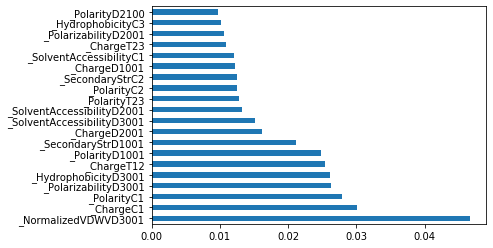

In [10]:
model = ExtraTreesClassifier()
model.fit(X_train,y_train)
importance = pd.Series(model.feature_importances_, index=headers)
importance.nlargest(20).plot(kind='barh')

In [7]:
# classifiers

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="linear", C=0.025),
    SVC(gamma="scale", C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=40),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [ ]:
# compare different classifiers

for name, clf in zip(names, classifiers):
    model = clf
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    report = classification_report(y_test, y_pred)
    print(name)
    print("accuracy: {}".format(accuracy))
    print("report:")
    print(report)


Nearest Neighbors
accuracy: 0.8177215189873418
report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      1414
           1       0.65      0.76      0.70       561

    accuracy                           0.82      1975
   macro avg       0.78      0.80      0.79      1975
weighted avg       0.83      0.82      0.82      1975

Linear SVM
accuracy: 0.9169620253164557
report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1414
           1       0.87      0.83      0.85       561

    accuracy                           0.92      1975
   macro avg       0.90      0.89      0.90      1975
weighted avg       0.92      0.92      0.92      1975

RBF SVM
accuracy: 0.9169620253164557
report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1414
           1       0.89      0.81      0.85       561

    accuracy                      